Hello this is me messing around with the lasso regression code from John Nardini (EQL_Tutorial.ipynb) trying to make is applicable to our code


In [2]:
#imports

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from utils import get_case_name

#below are the imports nardini used that I'm not sure what they do 

#from PDE_FIND3 import * 
#from model_selection_IP3 import *

import time, glob
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import os
import pdb




#increase font size throughout
font = {'size'   : 25}
plt.rc('font', **font)

/var/folders/qr/bhw9x9312cv578trmztshbf00000gn/T/ipykernel_15019/3663938427.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


Loading in the ABM data

In [3]:
#This part I'm confused about because I'm not 100% sure on loading the data..

#code copied from DataFormatter.py
def load_covasim_data_drums(file_path, population, case_name, keep_d=True, plot=True):
    '''
    Load covasim simulation data from .joblib file into dictionary/
    
    Args:
        file_path (str): name of the file path
        population (int): number of agents in population
        keep_d (bool): boolean value indicating whether or not to include D (diagnosed) in model
        case_name (str): case name of the simulation
        plot (bool): whether or not to plot simulation data
    
    Returns:
        params (dict): dictionary with values for each parameter of dataset
    '''

    file_name = 'covasim_' + str(case_name)

    params = joblib.load(file_path + file_name + '.joblib')

    if plot and isinstance(params['data'], pd.DataFrame):   #if plot is true and the data is a pd dataframe
        data = params['data']   #declaring the data from covasim as data
        n = data.shape[1]   #number of rows in data ??
        col_names = list(data.columns)
        t = np.arange(1, data.shape[0] + 1)  #an array of numbers from 1 to number of rows plus 1
        
        
        # plot compartments FOR ONE SIMULATION
        fig = plt.figure(figsize=(10, 7))
        for i in range(1, n + 1):    #range from 1 to the number of rows plus 1
            ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i) #subplot with n divided by 3 and rounded up num rows, 3 num cols and the element goes in the ith place
            ax.plot(t, data.iloc[:, i - 1], '.-', label=col_names[i - 1])   #plot t on x-axis, all rows of data and the i-1 column of data on the y- axis
            ax.legend()
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(file_path + file_name + '.png')
        plt.close()

    if plot and isinstance(params['data'], list):   #if plot is true and data is a list? a list of dataframes maybe?
        data = params['data']
        n = data[0].shape[1]    #num rows in the first element of the list
        col_names = list(data[0].columns)
        t = np.arange(1, data[0].shape[0] + 1)  #an array of numbers from 1 to number of rows in first item plus 1
       
       
       ##For averaging the simulations and plotting the average

        matrix_list = [df.values for df in data]    #turning dataframes into matricies
        matrix3d = np.array(matrix_list)    #turning list of matricies into 3d matrix
        mean_mat = np.mean(matrix3d, axis = 0)  #averaging each of the days for each state
        max_mat = np.max(matrix3d, axis = 0)    #getting the max of each of the days for each state
        min_mat = np.min(matrix3d, axis = 0)    #getting the min of each of the days for each state

        num_days= mean_mat.shape[0] #num rows in matrix
        days = range(num_days)  
        num_cols = mean_mat.shape[1]
        col_name = ["S", "T", "E", "A", "Y", "D", "Q", "R", "F"]    #names for the columns
        fig = plt.figure(figsize=(10, 7))
        for i in range(num_cols):    #iterating through each state and plotting them vs days in separate plots
            ax = fig.add_subplot(3, 3, i+1) #subplot with n divided by 3 and rounded up num rows, 3 num cols and the element goes in the ith place
            ax.plot(days, mean_mat[:,i])    #this is for the average line
            ax.fill_between(days, max_mat[:,i], min_mat[:,i], alpha=0.2, label='Error') #this is for the error cloud
            ax.set_title(col_name[i])   #this is to name each plot for their specific state
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        #plt.savefig(file_path + file_name + '.png')
        #plt.close()
        plt.show()
        
        '''
        # plot compartments EACH SIMULATION ON TOP OF EACH OHTER
        fig = plt.figure(figsize=(10, 7))
        for i in range(1, n + 1):
            ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)


            for j in range(len(data)):  
                #I think this for loop is for the multi simulation part, it would plot every iteration of each state on thier respective plot
                ax.plot(t, data[j].iloc[:, i - 1], '.-', label=col_names[i - 1] if j == 0 else '')

            ax.legend()
            fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(file_path + file_name + '.png')
        plt.close()

        '''
    return params

In [24]:
#the path will be used to tell the data loader function where our data is located
path = os.getcwd()  #This gets your current working directory 
path = path[:-10] + "/Data/covasim_data/drums_data/" #this deletes the "/Notebooks" and adds the rest of the path

#if files get moved around this path may not be accurate anymore


#enter the information for the joblib file you are looking to load
population = 50000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = False
multiple = True
n_runs = 1000
chi_type = 'piecewise'

#get_case_name takes in the info above and turns it into a file name (the same way we wrote the name of the joblib file)
case_name =  get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)




#this is changing the case name based off of if masking was used
if masking:
    case_name = case_name + '_masking'
    
if multiple:
    params = load_covasim_data_drums(path, population, case_name + '_' + str(n_runs), keep_d, plot=False)
    
else:
    params = load_covasim_data_drums(path, population, case_name, keep_d,  plot=False)
    




<class 'dict'>


Visualizing the ABM data 

In [43]:
'''
params is a dictionary!

to help visualize the dictionary: 

params.keys() are as follows: 
'tracing_array',    Numpy array of numbers
'population',       Population size
'alpha',            
'beta', 
'gamma', 
'mu', 
'tau', 
'tau_lb', 
'tau_ub', 
'lamda', 
'p_asymp', 
'n_contacts', 
'delta', 
'data',             This is a list of pandas dataframes (or just a dataframe if only one simulation was done) of values in each STEAYDQRF over time
'dynamic_tracing', 
'eff_ub'


print(params['tracing_array']) can be used to visualize information
'''

print(params["data"])


[         S    T    E    A    Y    D  Q      R    F
0    49900    0  100    0    0    0  0      0    0
1    49900    0  100    0    0    0  0      0    0
2    49899    0   93    2    6    0  0      0    0
3    49889    0   84   10   17    0  0      0    0
4    49875    0   71   20   33    1  0      0    0
..     ...  ...  ...  ...  ...  ... ..    ...  ...
178  28820  310  232  173  216  186  7  19941  115
179  28779  302  250  170  212  176  4  19991  116
180  28733  290  266  172  212  177  2  20032  116
181  28712  273  261  180  200  172  2  20084  116
182  28701  247  256  180  210  154  5  20131  116

[183 rows x 9 columns],          S    T    E    A    Y    D  Q      R    F
0    49900    0  100    0    0    0  0      0    0
1    49900    0  100    0    0    0  0      0    0
2    49900    0   94    1    5    0  0      0    0
3    49885    0   84   11   19    1  0      0    0
4    49861    0   78   20   40    1  0      0    0
..     ...  ...  ...  ...  ...  ... ..    ...  ...
178  

Graphing the average over multiple simulations, note this will only work if 'params['data']' is a list of MORE THAN ONE simulation

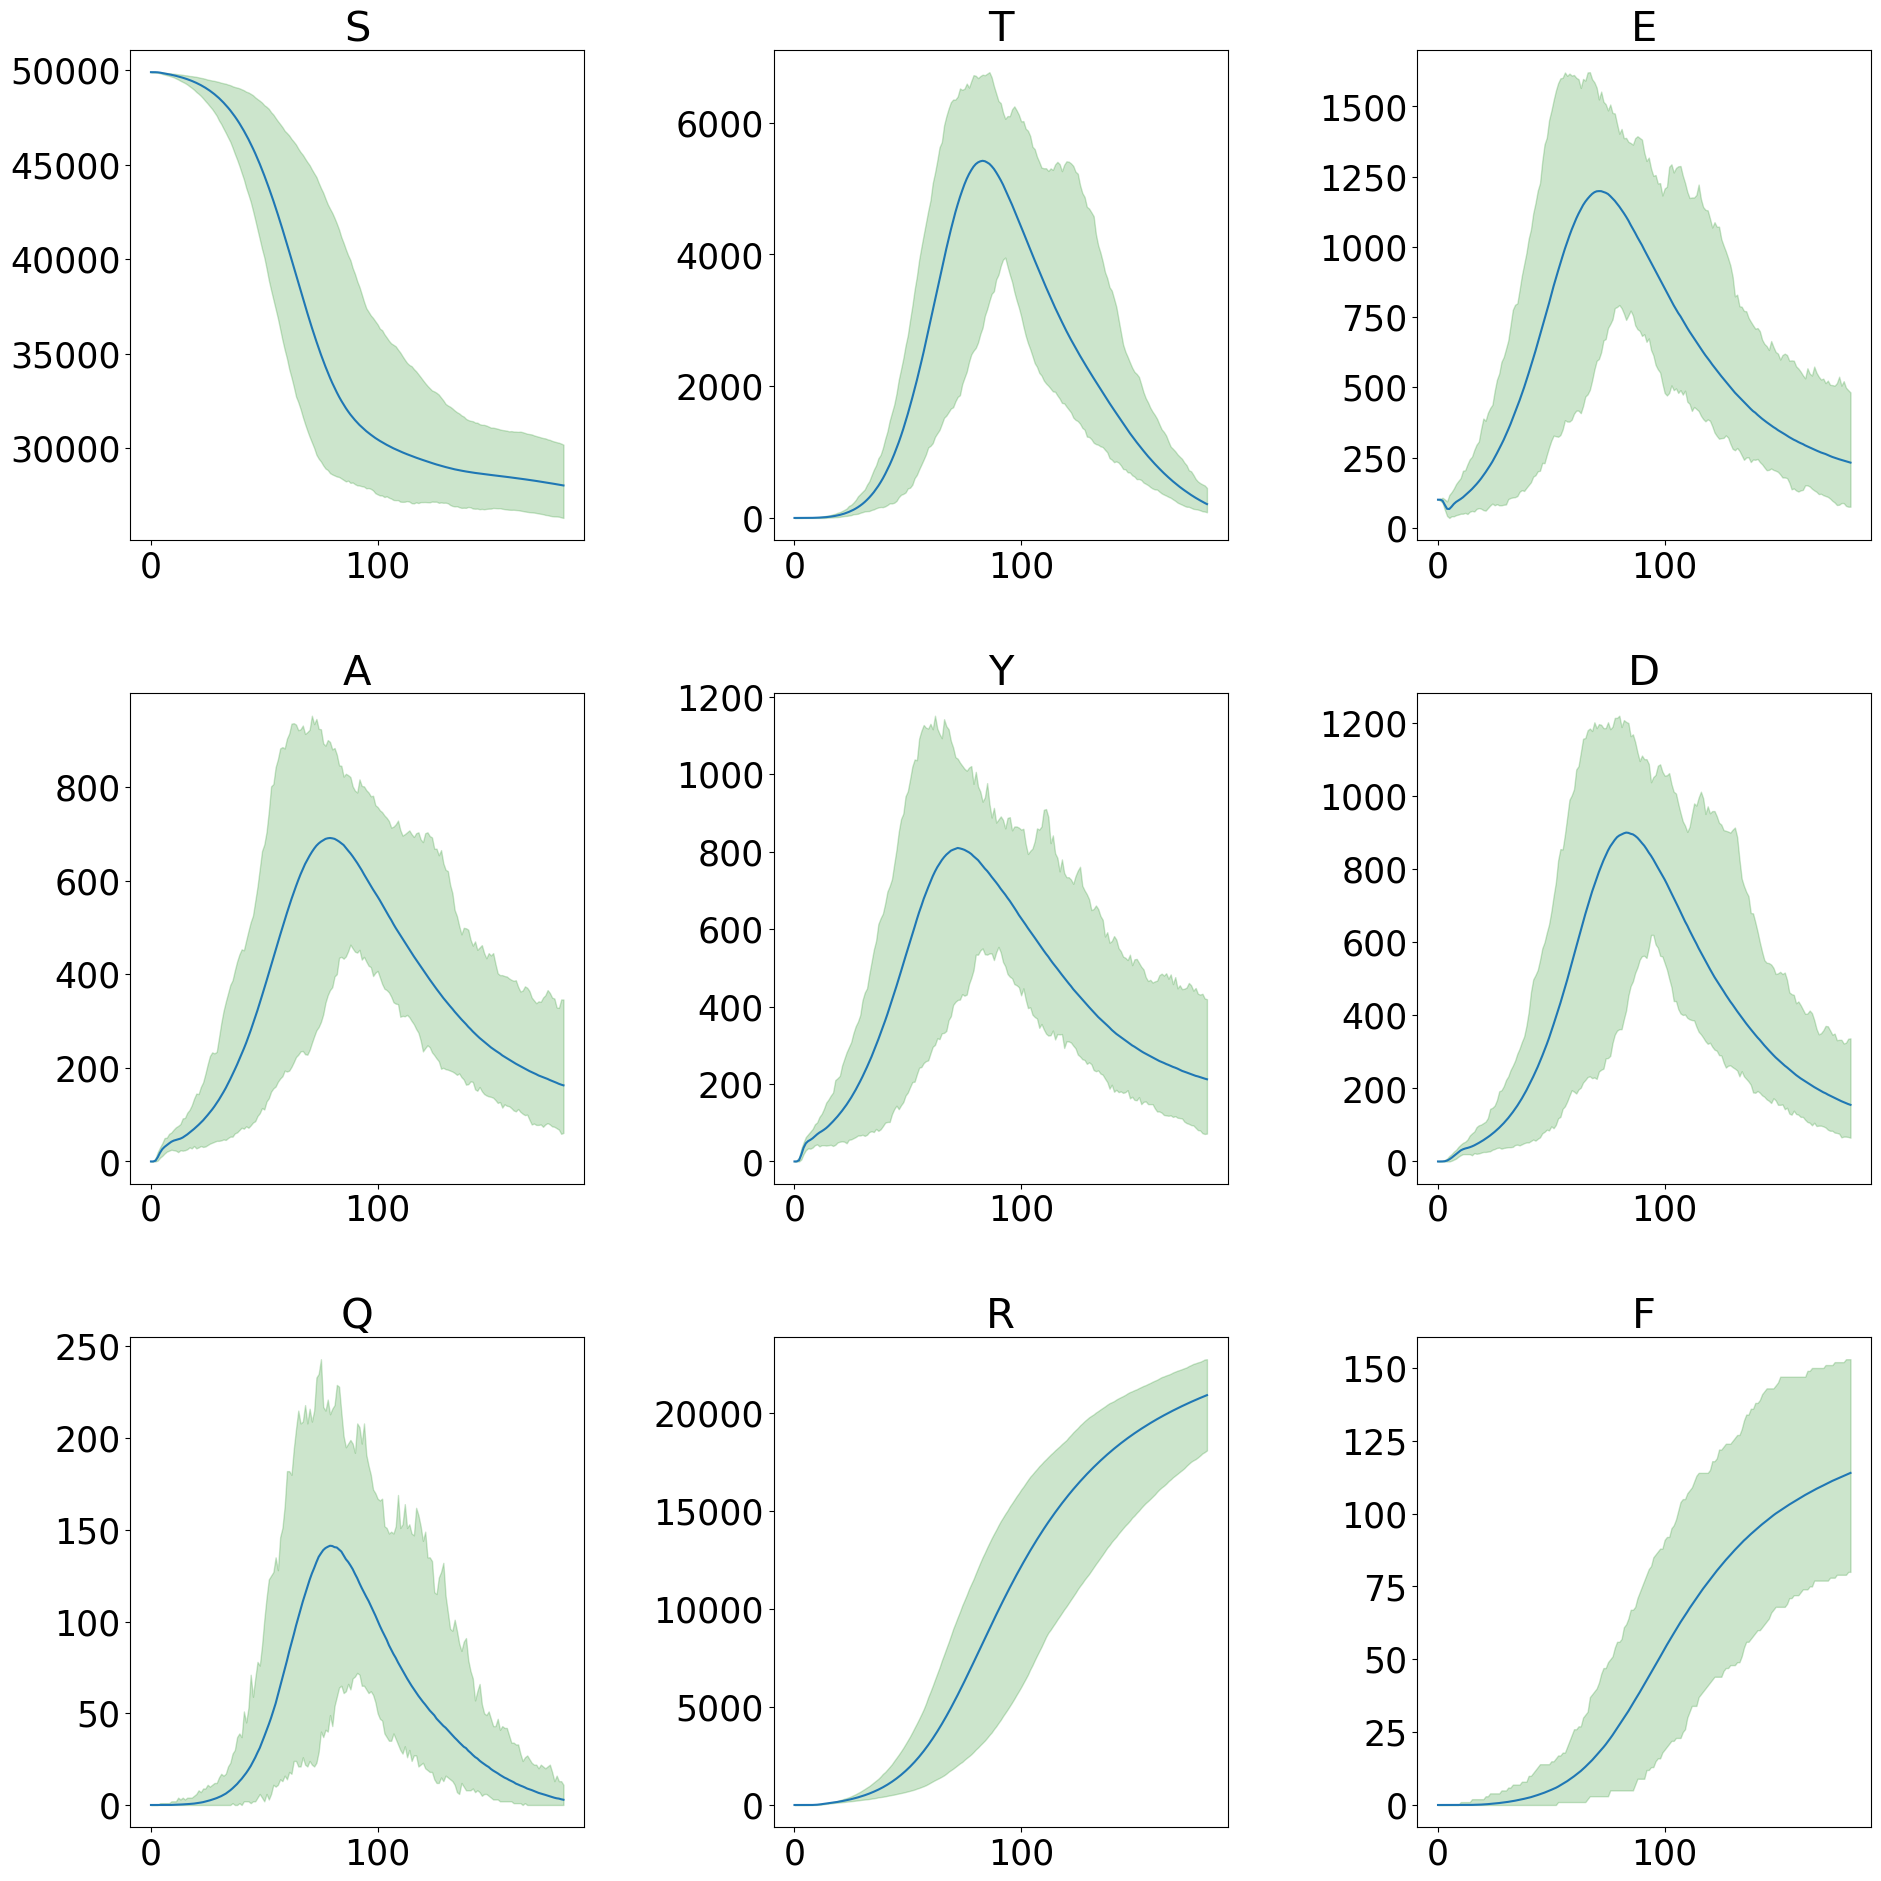

In [57]:
#if you have multiple simulations, the following code will take in the value for each compartment of STEAYDQRF for each day for each simulation and plot the average, with a cloud showing the min and max over time 
data = params['data']
matrix_list = [df.values for df in data]
matrix3d = np.array(matrix_list)
mean_mat = np.mean(matrix3d, axis = 0)
max_mat = np.max(matrix3d, axis = 0)
min_mat = np.min(matrix3d, axis = 0)

num_days= mean_mat.shape[0] #num rows in matrix
days = range(num_days)
num_cols = mean_mat.shape[1]
col_name = ["S", "T", "E", "A", "Y", "D", "Q", "R", "F"]
fig = plt.figure(figsize=(20, 20))

for i in range(num_cols):    
    ax = fig.add_subplot(3, 3, i+1) #subplot with n divided by 3 and rounded up num rows, 3 num cols and the element goes in the ith place
    ax.plot(days, mean_mat[:,i])
    ax.fill_between(days, max_mat[:,i], min_mat[:,i], alpha=0.2, label='Error', color = "green")
    ax.set_title(col_name[i])

    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=1)
plt.tight_layout(pad=2)
plt.show()
